In [1]:
!pip install --upgrade openpyxl scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633989 sha256=2564aa6ef205fda361c91a23712c76729ba4176cca4cd47eea8311a615bfc5a1
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/distributed_products.csv')
df.head()

,period,sub_market,client_class,division,brand,cat,product,client_code,client_name,kgs_sold,VentaGua,Margen%
0,201811,GRAN ASUNCIÓN,VTA,ALIMENTOS,QUAKER,AVENA,AVEN INST 400GR,30599,CON LOS DE HERMANOS,1,17273,20
1,201808,PREVENTA ASU,VTA,GASEOSAS,MIRINDA,DESCARTABLE,MIR GUA 500 CC,24084,FERNANDITO DESPENSA,1,17455,54
2,201809,PREVENTA ASU,VTA,GASEOSAS,MIRINDA,DESCARTABLE,MIR GUA 300 CC,29809,FARIMA MA KIOSKO LUJ,2,62727,44
3,201902,GRAN ASUNCIÓN,VTA,ALIMENTOS,TODDY,GALLETAS,TD EXTRA 100GR,4945,COMERCIAL SILV EMANU,1,21818,22
4,201901,GRAN ASUNCIÓN,VTA,GASEOSAS,MIRINDA,DESCARTABLE,MIR GUA 3 LTS,15436,DE DANIEL ESTHER DES,4,72636,43


In [15]:
df.columns.tolist()

['period',
 'sub_market',
 'client_class',
 'division',
 'brand',
 'cat',
 'product',
 'client_code',
 'client_name',
 'kgs_sold',
 'VentaGua',
 'Margen%']

In [16]:
len(df.client_name.unique())

60120

In [17]:
# Encontrar clientes que estuvieron reduciendo sus compras

In [18]:
kgs_by_period = df[['period','client_name','kgs_sold']]
kgs_by_period = kgs_by_period.groupby(['period','client_name']).sum().reset_index()
kgs_by_period.head()

,period,client_name,kgs_sold
0,201807,(MEDICOS SOUTH FOOD,107
1,201807,- AUTOSERVICE SAN M,2
2,201807,- DESPENSA DE LEON,1
3,201807,- RUFIN DESPENSA RU,1
4,201807,24 GONZALO HORAS OP,14


In [19]:
unique_clients = kgs_by_period.client_name.value_counts().reset_index()
unique_clients.columns = ['client_name','purchases']
unique_clients.head()

,client_name,purchases
0,SAN AUTOSERVICE CARL,8
1,MIGUEL DESPENSA SAN,8
2,COMERCIAL MEGA,8
3,MILAGROS DESPENSA,8
4,DESPENSA PAOLA,8


In [20]:
unique_clients.shape

(60119, 2)

In [21]:
# Filter top clients by number of purcheses
unique_clients = unique_clients[unique_clients.purchases>5]
unique_clients.head()

,client_name,purchases
0,SAN AUTOSERVICE CARL,8
1,MIGUEL DESPENSA SAN,8
2,COMERCIAL MEGA,8
3,MILAGROS DESPENSA,8
4,DESPENSA PAOLA,8


In [22]:
unique_clients.shape

(1052, 2)

In [23]:
kgs_by_client = df[['client_name','kgs_sold']]
kgs_by_client = kgs_by_client[kgs_by_client.client_name.isin(unique_clients.client_name)]
kgs_by_client = kgs_by_client.groupby(['client_name']).sum().reset_index()
kgs_by_client.columns = ['client','total_kgs']
kgs_by_client = kgs_by_client.sort_values(['total_kgs'],ascending= False)
kgs_by_client = kgs_by_client.head(25)
kgs_by_client.head()

,client,total_kgs
178,BK MARIANO,1277
443,DISTRIBUIDORA LEKAJA,783
552,GROUP SA KEOPS,714
179,BK MULTIPLAZA,697
690,MEGA COMERCIAL,653


In [24]:
kgs_by_client.to_csv('kgs_by_client_top_25.csv',index=False)

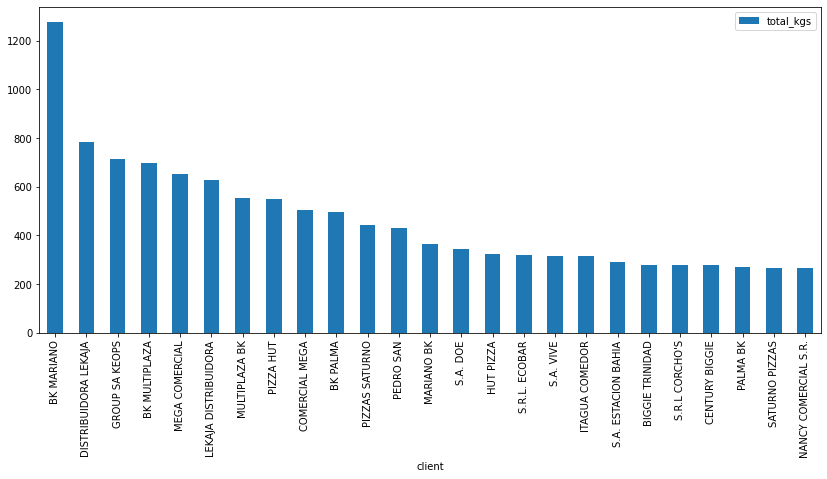

In [25]:
kgs_by_client.plot(kind='bar',x='client',y='total_kgs',figsize=(14,6),rot=90)

In [26]:
mask = kgs_by_period.client_name.isin(kgs_by_client.client)
kgs_by_period = kgs_by_period[mask]
kgs_by_period = kgs_by_period.sort_values(['kgs_sold'],ascending=False)
kgs_by_period

,period,client_name,kgs_sold
1250,201807,BK MULTIPLAZA,561
81315,201902,MULTIPLAZA BK,487
31207,201810,BK MARIANO,462
74682,201902,BK MARIANO,346
74684,201902,BK PALMA,326
...,...,...,...
16319,201808,MARIANO BK,0
38432,201810,PEDRO SAN,0
4554,201807,DISTRIBUIDORA LEKAJA,0
28289,201809,S.A. DOE,0


In [27]:
kgs_by_period.to_csv('kgs_by_client_and_period.csv',index=False)

In [28]:
dfx = kgs_by_period.pivot(index='period',columns='client_name',values='kgs_sold').reset_index()
dfx.columns.name = ''
dfx = dfx.fillna(0)
dfx

,period,BIGGIE TRINIDAD,BK MARIANO,BK MULTIPLAZA,BK PALMA,CENTURY BIGGIE,COMERCIAL MEGA,DISTRIBUIDORA LEKAJA,GROUP SA KEOPS,HUT PIZZA,...,PALMA BK,PEDRO SAN,PIZZA HUT,PIZZAS SATURNO,S.A. DOE,S.A. ESTACION BAHIA,S.A. VIVE,S.R.L CORCHO'S,S.R.L. ECOBAR,SATURNO PIZZAS
0,201807,2.0,281.0,561.0,0.0,75.0,52.0,0.0,259.0,3.0,...,152.0,104.0,45.0,95.0,0.0,5.0,69.0,5.0,30.0,18.0
1,201808,19.0,0.0,0.0,0.0,3.0,245.0,113.0,82.0,130.0,...,3.0,46.0,187.0,0.0,28.0,33.0,16.0,0.0,30.0,44.0
2,201809,21.0,76.0,0.0,7.0,77.0,5.0,169.0,26.0,134.0,...,0.0,4.0,1.0,25.0,0.0,138.0,23.0,0.0,38.0,136.0
3,201810,73.0,462.0,20.0,95.0,10.0,152.0,209.0,225.0,31.0,...,32.0,0.0,0.0,62.0,35.0,10.0,74.0,77.0,36.0,0.0
4,201811,45.0,6.0,85.0,51.0,60.0,14.0,0.0,0.0,1.0,...,76.0,210.0,27.0,0.0,0.0,12.0,6.0,83.0,18.0,0.0
5,201812,76.0,30.0,42.0,3.0,6.0,8.0,41.0,115.0,0.0,...,1.0,0.0,19.0,43.0,211.0,63.0,127.0,50.0,61.0,32.0
6,201901,40.0,76.0,-13.0,13.0,17.0,14.0,40.0,0.0,23.0,...,1.0,2.0,0.0,28.0,13.0,24.0,2.0,52.0,56.0,15.0
7,201902,4.0,346.0,2.0,326.0,29.0,15.0,211.0,7.0,0.0,...,3.0,64.0,270.0,189.0,55.0,4.0,0.0,10.0,50.0,21.0


In [29]:
dfx.to_csv('kgs_by_client_and_period_pivot.csv',index=False)

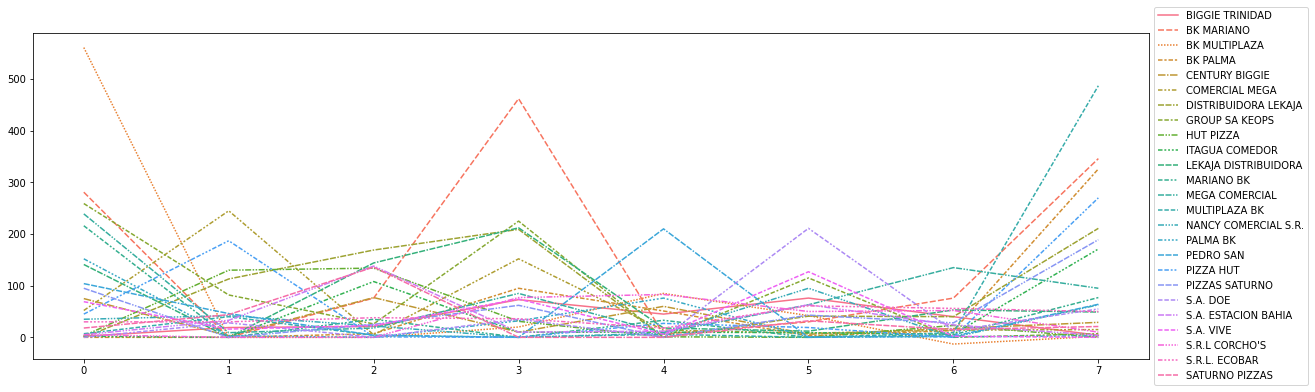

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt # visualization

f, ax = plt.subplots(figsize=(20, 6))
# Load the long-form example gammas dataset
g = sns.lineplot(data=dfx.drop(['period'],axis=1))

# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [31]:
dfx.head()

,period,BIGGIE TRINIDAD,BK MARIANO,BK MULTIPLAZA,BK PALMA,CENTURY BIGGIE,COMERCIAL MEGA,DISTRIBUIDORA LEKAJA,GROUP SA KEOPS,HUT PIZZA,...,PALMA BK,PEDRO SAN,PIZZA HUT,PIZZAS SATURNO,S.A. DOE,S.A. ESTACION BAHIA,S.A. VIVE,S.R.L CORCHO'S,S.R.L. ECOBAR,SATURNO PIZZAS
0,201807,2.0,281.0,561.0,0.0,75.0,52.0,0.0,259.0,3.0,...,152.0,104.0,45.0,95.0,0.0,5.0,69.0,5.0,30.0,18.0
1,201808,19.0,0.0,0.0,0.0,3.0,245.0,113.0,82.0,130.0,...,3.0,46.0,187.0,0.0,28.0,33.0,16.0,0.0,30.0,44.0
2,201809,21.0,76.0,0.0,7.0,77.0,5.0,169.0,26.0,134.0,...,0.0,4.0,1.0,25.0,0.0,138.0,23.0,0.0,38.0,136.0
3,201810,73.0,462.0,20.0,95.0,10.0,152.0,209.0,225.0,31.0,...,32.0,0.0,0.0,62.0,35.0,10.0,74.0,77.0,36.0,0.0
4,201811,45.0,6.0,85.0,51.0,60.0,14.0,0.0,0.0,1.0,...,76.0,210.0,27.0,0.0,0.0,12.0,6.0,83.0,18.0,0.0


In [32]:
from scipy import stats

results = []
for i in range(1,dfx.shape[1]):
  client = dfx.columns[i]
  slope, intercept, r_value, p_value, std_err = stats.linregress(dfx.index,dfx.iloc[0:,i])
  results.append([client,slope,std_err])
  print('Client Name:',client,'; Buy Tendency (Slope):',round(slope,3),'; Common Standard deviation:',round(std_err,3))

Client Name: BIGGIE TRINIDAD ; Buy Tendency (Slope): 3.048 ; Common Standard deviation: 4.613
Client Name: BK MARIANO ; Buy Tendency (Slope): 2.869 ; Common Standard deviation: 29.575
Client Name: BK MULTIPLAZA ; Buy Tendency (Slope): -45.083 ; Common Standard deviation: 26.592
Client Name: BK PALMA ; Buy Tendency (Slope): 27.274 ; Common Standard deviation: 14.942
Client Name: CENTURY BIGGIE ; Buy Tendency (Slope): -4.94 ; Common Standard deviation: 4.803
Client Name: COMERCIAL MEGA ; Buy Tendency (Slope): -18.369 ; Common Standard deviation: 12.676
Client Name: DISTRIBUIDORA LEKAJA ; Buy Tendency (Slope): 6.179 ; Common Standard deviation: 14.716
Client Name: GROUP SA KEOPS ; Buy Tendency (Slope): -25.381 ; Common Standard deviation: 13.744
Client Name: HUT PIZZA ; Buy Tendency (Slope): -11.762 ; Common Standard deviation: 8.354
Client Name: ITAGUA COMEDOR ; Buy Tendency (Slope): 10.905 ; Common Standard deviation: 9.708
Client Name: LEKAJA DISTRIBUIDORA ; Buy Tendency (Slope): -11.5

In [33]:
results_df = pd.DataFrame(results).dropna()
results_df.columns = ['client','slope','std']
results_df.index = results_df.client
results_df = results_df.drop(['client'],axis=1)
results_df.head()

,slope,std
client,,
BIGGIE TRINIDAD,3.047619,4.612743
BK MARIANO,2.869048,29.575177
BK MULTIPLAZA,-45.083333,26.591530
BK PALMA,27.273810,14.941516
CENTURY BIGGIE,-4.940476,4.802746


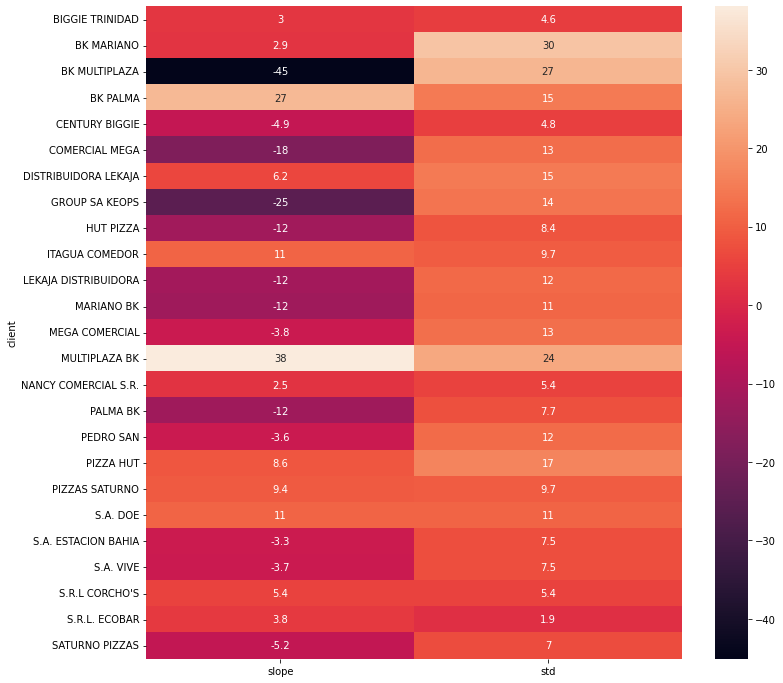

In [34]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(results_df, annot=True)

In [35]:
results_df.to_csv('slope_std_heatmap.csv')

# Product Recommendation

In [36]:
df.head()

,period,sub_market,client_class,division,brand,cat,product,client_code,client_name,kgs_sold,VentaGua,Margen%
0,201811,GRAN ASUNCIÓN,VTA,ALIMENTOS,QUAKER,AVENA,AVEN INST 400GR,30599,CON LOS DE HERMANOS,1,17273,20
1,201808,PREVENTA ASU,VTA,GASEOSAS,MIRINDA,DESCARTABLE,MIR GUA 500 CC,24084,FERNANDITO DESPENSA,1,17455,54
2,201809,PREVENTA ASU,VTA,GASEOSAS,MIRINDA,DESCARTABLE,MIR GUA 300 CC,29809,FARIMA MA KIOSKO LUJ,2,62727,44
3,201902,GRAN ASUNCIÓN,VTA,ALIMENTOS,TODDY,GALLETAS,TD EXTRA 100GR,4945,COMERCIAL SILV EMANU,1,21818,22
4,201901,GRAN ASUNCIÓN,VTA,GASEOSAS,MIRINDA,DESCARTABLE,MIR GUA 3 LTS,15436,DE DANIEL ESTHER DES,4,72636,43


In [37]:
dfs = df[['client_name','product']].groupby(['client_name','product']).size().reset_index(name='counts')
dfs =  dfs.sort_values(['counts'],ascending=False)
dfs.head()

,client_name,product,counts
83212,S.R.L. ECOBAR,MIR GUA 2 LTS,8
44581,DESPENSA SAN CAYETAN,SPLIT GUA 3LTS,8
76334,PETROMAX,PDT PO 300 CC,7
84673,SAN CAYETANO DESPENS,SPLIT GUA 3LTS,7
75947,PETROBRAS,PEPSI 500CC,7


In [38]:
# Entrenamos un recomendador sobre una escala entre 0 y 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

dfs['count_sc'] = scaler.fit_transform(dfs[['counts']])
# dfs['count_sc'] = dfs['counts']/dfs['counts'].max()
dfs = dfs.drop(['counts'],axis=1)
dfs.head()

,client_name,product,count_sc
83212,S.R.L. ECOBAR,MIR GUA 2 LTS,1.000000
44581,DESPENSA SAN CAYETAN,SPLIT GUA 3LTS,1.000000
76334,PETROMAX,PDT PO 300 CC,0.857143
84673,SAN CAYETANO DESPENS,SPLIT GUA 3LTS,0.857143
75947,PETROBRAS,PEPSI 500CC,0.857143


In [39]:
from surprise import SVDpp
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0,1))
# Remove 
data = Dataset.load_from_df(dfs, reader)

algo = SVDpp()
algo.fit(data.build_full_trainset())

In [40]:
usr = 'LA TROYA'
# Products that the client is already buying
user_prods = dfs[dfs.client_name==usr]['product'].unique().tolist()
# The total numbers
prods = dfs[dfs.client_name!=usr]['product'].unique().tolist()
# Filter the products that the client is already buying
prods = [p for p in prods if p not in user_prods]

my_recs = []
for iid in prods:
    my_recs.append((iid, algo.predict(uid=usr,iid=iid).est))

In [41]:
# Para cada usuario calculamos el rating de cada producto que no están comprando
dk = pd.DataFrame(my_recs)
dk.columns = ['product', 'rating']
dk = dk.sort_values('rating',ascending= False).reset_index(drop=True)
dk.head()

,product,rating
0,3D 66G,0.116697
1,"GUA FREE 1,5 LT",0.088166
2,TWIS 4Q 112G,0.087357
3,TWIS 4Q 45G,0.079753
4,POLEN MAGICA,0.077391


In [42]:
# Para cada usuario calculamos el rating de cada producto que no están comprando
dki_full = pd.DataFrame()
# For top 25 clients
users = kgs_by_period.client_name.unique()

for usr in users:
  print(usr)
  user_prods = dfs[dfs.client_name==usr]['product'].unique().tolist()
  prods = dfs[dfs.client_name!=usr]['product'].unique().tolist()
  prods = [p for p in prods if p not in user_prods]

  my_recs = []
  for iid in prods:
      my_recs.append((iid, algo.predict(uid=usr,iid=iid).est))

  dk = pd.DataFrame(my_recs)
  dk.columns = ['product', 'rating']
  dk = dk.sort_values('rating',ascending= False).reset_index(drop=True)
  dk['client'] = usr
  dki_full = pd.concat([dki_full, dk.head(20)])

BK MULTIPLAZA
MULTIPLAZA BK
BK MARIANO
BK PALMA
PIZZA HUT
GROUP SA KEOPS
COMERCIAL MEGA
MEGA COMERCIAL
MARIANO BK
LEKAJA DISTRIBUIDORA
DISTRIBUIDORA LEKAJA
S.A. DOE
PEDRO SAN
PIZZAS SATURNO
ITAGUA COMEDOR
PALMA BK
S.A. ESTACION BAHIA
SATURNO PIZZAS
HUT PIZZA
S.A. VIVE
NANCY COMERCIAL S.R.
S.R.L CORCHO'S
CENTURY BIGGIE
BIGGIE TRINIDAD
S.R.L. ECOBAR


In [43]:
dki_full

,product,rating,client
0,DESC. OTORGADO,0.145976,BK MULTIPLAZA
1,7 UP BIB 12 LTS,0.144161,BK MULTIPLAZA
2,SPLIT 2LX6 MULT,0.111841,BK MULTIPLAZA
3,TWIS JAM 45G,0.110069,BK MULTIPLAZA
4,TWIS CR OL 100G,0.109489,BK MULTIPLAZA
...,...,...,...
15,QK BARRA FRUT,0.257141,S.R.L. ECOBAR
16,7 UP 500 CC,0.255076,S.R.L. ECOBAR
17,DESCUENTO SPLIT,0.254407,S.R.L. ECOBAR
18,1PC 3L+1MG 3L+V,0.253876,S.R.L. ECOBAR


In [44]:
dki_full.to_csv('recommendations_25_top.csv',index=False)

In [ ]:
import pandas as pd

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Loading the Data
data = pd.read_csv('/content/Online Retail.csv',encoding='iso-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
# Exploring the columns of the data
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
data.describe(include='O')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,31/10/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


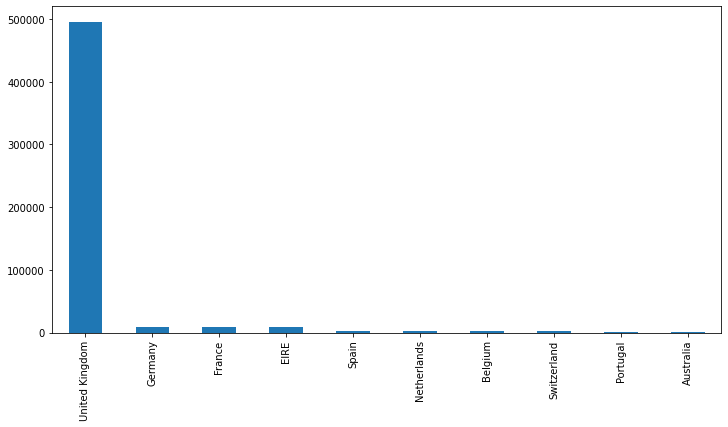

In [ ]:
# Exploring the different regions of transactions
data['Country'].value_counts().head(10).plot(kind='bar',figsize=(12,6))

In [ ]:
# Stripping extra spaces in the description
data['Description'] = data['Description'].str.strip()

# Drop rows with NaNs in the Invoice number and convert them into strings for categorical treatment
data = data[~data['InvoiceNo'].isna()]
data['InvoiceNo'] = data['InvoiceNo'].astype('str')

# Dropping all transactions which were done on credit
data = data[~data['InvoiceNo'].str.contains('C')]

In [ ]:
# Transactions done in the United Kingdom
data_uk = data[data['Country'] =="United Kingdom"]
basket_uk = data_uk.groupby(['InvoiceNo', 'Description'])['Quantity'].sum()
basket_uk = basket_uk.unstack().reset_index().fillna(0)
basket_uk = basket_uk.set_index('InvoiceNo')
basket_uk.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Transactions done in France
basket_fr = data[data['Country'] =="France"]
basket_fr = basket_fr.groupby(['InvoiceNo', 'Description'])['Quantity'].sum()
basket_fr = basket_fr.unstack().reset_index().fillna(0)
basket_fr = basket_fr.set_index('InvoiceNo')
basket_fr.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Transactions done in germany
basket_de = data[data['Country'] =="Germany"]
basket_de = basket_de.groupby(['InvoiceNo', 'Description'])['Quantity'].sum()
basket_de = basket_de.unstack().reset_index().fillna(0)
basket_de = basket_de.set_index('InvoiceNo')
basket_de.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Defining the hot encoding function to make the data suitable
# for the concerned libraries
basket_uk = (basket_uk>0).astype(int)
basket_fr = (basket_fr>0).astype(int)
basket_de = (basket_de>0).astype(int)

In [ ]:
# Building the model
frq_items_uk = apriori(basket_uk, min_support = 0.05, use_colnames = True)

# Collecting the inferred rules in a dataframe
rules_uk = association_rules(frq_items_uk, metric ="lift", min_threshold = 1)
# rules_uk = rules_uk.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_uk.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [ ]:
# Building the model
frq_items_fr = apriori(basket_fr, min_support = 0.05, use_colnames = True)

# Collecting the inferred rules in a dataframe
rules_fr = association_rules(frq_items_fr, metric ="lift", min_threshold = 1)
rules_fr = rules_fr.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_fr.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,(JUMBO BAG WOODLAND ANIMALS),(POSTAGE),0.076531,0.765306,0.076531,1.000,1.306667,0.017961,inf
258,"(RED TOADSTOOL LED NIGHT LIGHT, PLASTERS IN TI...",(POSTAGE),0.051020,0.765306,0.051020,1.000,1.306667,0.011974,inf
271,"(RED TOADSTOOL LED NIGHT LIGHT, PLASTERS IN TI...",(POSTAGE),0.053571,0.765306,0.053571,1.000,1.306667,0.012573,inf
302,"(SET/6 RED SPOTTY PAPER CUPS, SET/20 RED RETRO...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975,7.644000,0.086474,34.897959
301,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975,7.077778,0.085433,34.489796


In [ ]:
# Building the model
frq_items_de = apriori(basket_de, min_support = 0.05, use_colnames = True)

# Collecting the inferred rules in a dataframe
rules_de = association_rules(frq_items_de, metric ="lift", min_threshold = 1)
rules_de = rules_de.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_de.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,(PLASTERS IN TIN STRONGMAN),(POSTAGE),0.070022,0.818381,0.067834,0.968750,1.183740,0.010529,5.811816
50,(RETROSPOT TEA SET CERAMIC 11 PC),(POSTAGE),0.056893,0.818381,0.054705,0.961538,1.174928,0.008145,4.722101
53,(ROUND SNACK BOXES SET OF 4 FRUITS),(POSTAGE),0.157549,0.818381,0.150985,0.958333,1.171012,0.022049,4.358862
104,"(ROUND SNACK BOXES SET OF4 WOODLAND, ROUND SNA...",(POSTAGE),0.131291,0.818381,0.124726,0.950000,1.160829,0.017280,3.632385
33,(PLASTERS IN TIN SPACEBOY),(POSTAGE),0.107221,0.818381,0.100656,0.938776,1.147113,0.012909,2.966448
